In [1]:
from dask.distributed import Client
from sklearn.linear_model import LogisticRegression
from dpyacl.experiment import ExperimentAnalyserFactory

client = Client("tcp://192.168.2.100:8786")
client

Client Scheduler: tcp://192.168.2.100:8786 Dashboard: http://192.168.2.100:8787/status,Cluster Workers: 3 Cores: 6 Memory: 60.00 GB


In [2]:
import dask.array as da

from sklearn.datasets import  make_classification
from dpyacl.strategies.single_label import QueryMarginSampling
from dpyacl.core.stop_criteria import MaxIteration
from dpyacl.experiment.context import HoldOutExperiment
from dpyacl.metrics import Accuracy
from dpyacl.metrics.evaluation import F1, Precision, Recall
from dpyacl.oracle import SimulatedOracleQueryIndex
from dpyacl.scenario.scenario import PoolBasedSamplingScenario

from dpyacl.core.misc import split


In [3]:
_split_count = 1
_feature_num = 10
_label_num = 3
_instance_num = 1000

_X, _y = make_classification(n_samples=_instance_num, n_features=_feature_num, n_informative=2*_label_num, n_redundant=_label_num,
                             n_repeated=0, n_classes=_label_num, n_clusters_per_class=_label_num, weights=None,
                             flip_y=0.01,
                             class_sep=1.0,
                             hypercube=True, shift=0.0, scale=1.0, shuffle=True, random_state=None)

_X = da.from_array(_X, chunks="64MB")
_y = da.from_array(_y, chunks="64MB")

_X

dask.array<array, shape=(1000, 10), dtype=float64, chunksize=(1000, 10), chunktype=numpy.ndarray>

In [4]:
%%time
train_idx, test_idx, label_idx, unlabel_idx = split(X=_X,
                                                    y=_X,
                                                    all_class=True,
                                                    split_count=_split_count,
                                                    test_ratio=0.3,
                                                    initial_label_rate=0.05)

train_idx, test_idx, label_idx, unlabel_idx



CPU times: user 38.6 ms, sys: 0 ns, total: 38.6 ms
Wall time: 87 ms


([array([650, 435, 446, 322, 528, 168, 997, 917, 240, 234, 230, 844, 734,
         828, 178, 365, 762, 389, 101, 985, 367, 299, 281, 378, 260, 392,
         686, 108, 733, 572, 224, 478, 517, 626, 162, 225, 804, 318, 413,
         438, 565, 973, 393,  20, 697, 282, 288, 394,  70, 622, 222, 979,
         238, 775,  74, 485, 634, 774, 550, 817, 490, 617, 120, 840, 118,
         689,  50, 316,  34, 674, 107, 294, 978, 862, 753, 824, 615, 503,
         611, 647, 621, 582, 325, 126, 494, 867,  14, 720, 558, 499, 137,
         859, 398, 391, 364, 466, 746, 793, 308,  53, 471, 661, 913,  84,
         343, 988, 627, 100,  58, 680, 972, 970, 799, 960, 984, 982, 342,
         624, 540, 349, 139, 573, 560, 436, 604,  28,  11, 861, 259, 420,
         893, 417, 692, 505, 289, 598, 488, 239, 545, 755, 914, 635, 261,
         745, 464, 246, 267, 834, 460, 990, 130, 763, 795, 218, 700, 416,
         395, 269, 736, 451, 613, 201, 184, 172, 113, 825, 811, 183, 948,
          22, 237, 737, 223, 556, 200,

In [5]:
ml_technique = LogisticRegression(solver='sag')
stopping_criteria = MaxIteration(50)
query_strategy =  QueryMarginSampling()
performance_metrics = [
                Accuracy(),
                F1(average='macro'),
                Precision(average='macro'),
                Recall(average='macro')]

experiment = HoldOutExperiment(
    _X,
    _y,
    scenario_type=PoolBasedSamplingScenario,
    train_idx=train_idx,
    test_idx=test_idx,
    label_idx=label_idx,
    unlabel_idx=unlabel_idx,
    ml_technique=ml_technique,
    performance_metrics=performance_metrics,
    query_strategy=query_strategy,
    oracle=SimulatedOracleQueryIndex(labels=_y),
    stopping_criteria=stopping_criteria,
    self_partition=False
)

In [6]:
result = experiment.evaluate(verbose=True)

Label: [1], Cost: [1]

| round | initially labeled data | number of queries | cost | accuracy_score: |  f1_score:   | precision_score: | recall_score: |
|   0   |    35 (5.00% of all)   |         1         |  0   |   0.463 ± 0.00  | 0.447 ± 0.00 |   0.472 ± 0.00   |  0.463 ± 0.00 |Label: [1], Cost: [1]
|   0   |    35 (5.00% of all)   |         2         |  0   |   0.458 ± 0.01  | 0.441 ± 0.01 |   0.468 ± 0.00   |  0.459 ± 0.00 |Label: [0], Cost: [1]
|   0   |    35 (5.00% of all)   |         3         |  0   |   0.458 ± 0.00  | 0.440 ± 0.00 |   0.467 ± 0.00   |  0.458 ± 0.00 |Label: [1], Cost: [1]
|   0   |    35 (5.00% of all)   |         4         |  0   |   0.460 ± 0.01  | 0.442 ± 0.01 |   0.469 ± 0.00   |  0.460 ± 0.01 |Label: [0], Cost: [1]
|   0   |    35 (5.00% of all)   |         5         |  0   |   0.461 ± 0.00  | 0.442 ± 0.00 |   0.469 ± 0.00   |  0.461 ± 0.00 |Label: [0], Cost: [1]
|   0   |    35 (5.00% of all)   |         6         |  0   |   0.463 ± 0.01  | 0.444 ± 0.01

distributed.client - WARNING - Couldn't gather 1 keys, rescheduling {"('getitem-08b009761b1d1cceaf253d5bbb506ef7', 0)": ()}
distributed.client - WARNING - Couldn't gather 1 keys, rescheduling {"('getitem-08b009761b1d1cceaf253d5bbb506ef7', 0)": ()}
distributed.client - WARNING - Couldn't gather 1 keys, rescheduling {"('getitem-08b009761b1d1cceaf253d5bbb506ef7', 0)": ()}
distributed.client - WARNING - Couldn't gather 1 keys, rescheduling {"('getitem-08b009761b1d1cceaf253d5bbb506ef7', 0)": ()}
distributed.client - WARNING - Couldn't gather 1 keys, rescheduling {"('getitem-08b009761b1d1cceaf253d5bbb506ef7', 0)": ()}
distributed.client - WARNING - Couldn't gather 1 keys, rescheduling {"('getitem-08b009761b1d1cceaf253d5bbb506ef7', 0)": ()}
distributed.client - WARNING - Couldn't gather 1 keys, rescheduling {"('getitem-08b009761b1d1cceaf253d5bbb506ef7', 0)": ()}
distributed.client - WARNING - Couldn't gather 1 keys, rescheduling {"('getitem-08b009761b1d1cceaf253d5bbb506ef7', 0)": ()}
distribu

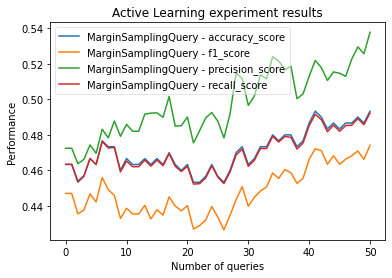

In [7]:
query_analyser = ExperimentAnalyserFactory.experiment_analyser(
                            performance_metrics= [metric.metric_name for metric in performance_metrics],
                            method_name=query_strategy.query_function_name,
                            method_results=result,
                            type="queries"
                        )

# get a brief description of the experiment
query_analyser.plot_learning_curves(title='Active Learning experiment results')

